In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from keras.models import Sequential
from keras.layers import Dense, LSTM, BatchNormalization, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
import matplotlib.pyplot as plt
import time
from imblearn.over_sampling import SMOTE


def create_dataset(dataset, y, look_back=4):
    X, Y = [], []
    for i in range(look_back, len(dataset)):
        a = dataset[i-look_back:i+1, :]
        X.append(a)
        Y.append(y[i])
    return np.array(X), np.array(Y)

In [ ]:
# Loading the data and preprocessing

excel_path = 'S&P 500 Index Dataset.xlsx'
snp500 = pd.read_excel(excel_path, sheet_name=1, header=0, index_col=0, parse_dates=False)

# the direction after t+5
snp500['Direction'] = (snp500['Close'].shift(-5)>snp500['Close']).astype(int)
snp500 = snp500.dropna()
snp500.tail(15)

# keep the last 100 observations for testing
snp500_train = snp500.iloc[:-100]
snp500_test = snp500.iloc[-100:]

# input
X = snp500_train.drop(columns=['Direction'])
# output
Y = snp500_train['Direction']

In [ ]:
# PCA with d = 32
d = 32
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(X)
pca = PCA(n_components=d, random_state=1)
df_pca = pca.fit_transform(df_scaled)

# look back to X=t-4, t-3, t-2, t-1, t and Y=t['Direction']
look_back = 9
X, Y = create_dataset(df_pca, snp500_train['Direction'].values, look_back)

print(X.shape, Y.shape)

# splitting the train and val set
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=1)

# X_train = np.reshape(X_train, (X_train.shape[0], look_back, X_train.shape[1]))
# X_test = np.reshape(X_test, (X_test.shape[0], look_back, X_test.shape[1]))

(8884, 10, 32) (8884,)


In [ ]:
LSTM_model = Sequential()
kernel_regularizer = kernel_regularizer=l2(0.001)
LSTM_units = 50
# first layer
LSTM_model.add(LSTM(LSTM_units,return_sequences=True, input_shape=(look_back+1, d), kernel_regularizer=kernel_regularizer))
LSTM_model.add(Dropout(0.2))
LSTM_model.add(BatchNormalization())
# second layer
LSTM_model.add(LSTM(LSTM_units,return_sequences=True, kernel_regularizer=kernel_regularizer))
LSTM_model.add(Dropout(0.2))
LSTM_model.add(BatchNormalization())
# third layer
LSTM_model.add(LSTM(LSTM_units, return_sequences=True, kernel_regularizer=kernel_regularizer))
LSTM_model.add(Dropout(0.2))
LSTM_model.add(BatchNormalization())
# forth layer
LSTM_model.add(LSTM(LSTM_units, return_sequences=True, kernel_regularizer=kernel_regularizer))
LSTM_model.add(Dropout(0.2))
LSTM_model.add(BatchNormalization())
# forth layer
LSTM_model.add(LSTM(LSTM_units, return_sequences=True, kernel_regularizer=kernel_regularizer))
LSTM_model.add(Dropout(0.2))
LSTM_model.add(BatchNormalization())
# forth layer
LSTM_model.add(LSTM(LSTM_units, return_sequences=True, kernel_regularizer=kernel_regularizer))
LSTM_model.add(Dropout(0.2))
LSTM_model.add(BatchNormalization())
# forth layer
LSTM_model.add(LSTM(LSTM_units, return_sequences=True, kernel_regularizer=kernel_regularizer))
LSTM_model.add(Dropout(0.2))
LSTM_model.add(BatchNormalization())
# forth layer
LSTM_model.add(LSTM(LSTM_units, return_sequences=True, kernel_regularizer=kernel_regularizer))
LSTM_model.add(Dropout(0.2))
LSTM_model.add(BatchNormalization())
# forth layer
LSTM_model.add(LSTM(LSTM_units, return_sequences=True, kernel_regularizer=kernel_regularizer))
LSTM_model.add(Dropout(0.2))
LSTM_model.add(BatchNormalization())
# fifth layer
LSTM_model.add(LSTM(LSTM_units, kernel_regularizer=kernel_regularizer))
LSTM_model.add(Dropout(0.2))
LSTM_model.add(BatchNormalization())

LSTM_model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.001)
LSTM_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

Epoch 1/1000
14/14 [==============================] - 24s 279ms/step - loss: 1.6039 - accuracy: 0.4977 - val_loss: 1.4433 - val_accuracy: 0.5723
Epoch 2/1000
14/14 [==============================] - 0s 36ms/step - loss: 1.5164 - accuracy: 0.5212 - val_loss: 1.4190 - val_accuracy: 0.5723
Epoch 3/1000
14/14 [==============================] - 0s 35ms/step - loss: 1.4658 - accuracy: 0.5382 - val_loss: 1.3948 - val_accuracy: 0.5723
Epoch 4/1000
14/14 [==============================] - 0s 36ms/step - loss: 1.4349 - accuracy: 0.5378 - val_loss: 1.3704 - val_accuracy: 0.5723
Epoch 5/1000
14/14 [==============================] - 0s 34ms/step - loss: 1.3983 - accuracy: 0.5476 - val_loss: 1.3451 - val_accuracy: 0.5723
Epoch 6/1000
14/14 [==============================] - 0s 36ms/step - loss: 1.3707 - accuracy: 0.5545 - val_loss: 1.3200 - val_accuracy: 0.5723
Epoch 7/1000
14/14 [==============================] - 0s 35ms/step - loss: 1.3441 - accuracy: 0.5531 - val_loss: 1.2953 - val_accuracy: 0.57

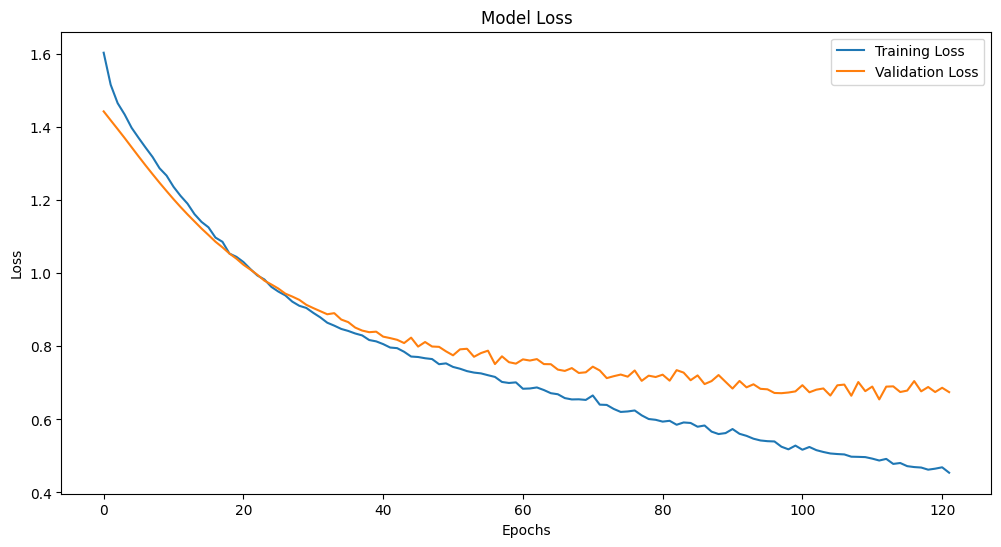

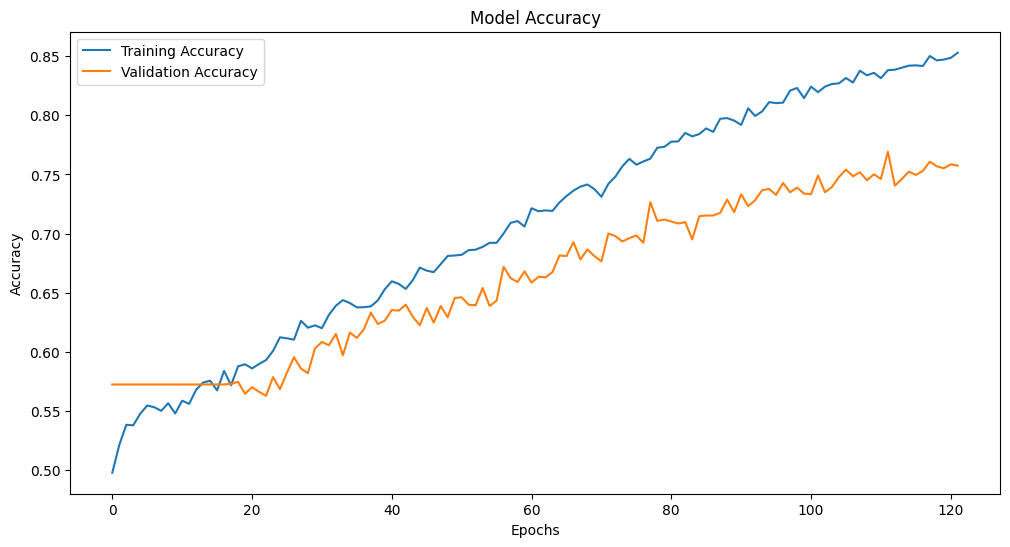

In [ ]:
# class_weight = {0: 2.,
#                 1: 1.}
# training the model
start=time.time()
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
history = LSTM_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=1000, batch_size = 512, callbacks=[early_stopping])
end=time.time()
print("Running Time:", end - start)
# LSTM_model.save('LSTM_model.h5')

# Plotting the loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

# Plotting the accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

56/56 [==============================] - 4s 12ms/step
              precision    recall  f1-score   support

           0       0.71      0.74      0.72       760
           1       0.80      0.77      0.78      1017

    accuracy                           0.76      1777
   macro avg       0.75      0.76      0.75      1777
weighted avg       0.76      0.76      0.76      1777



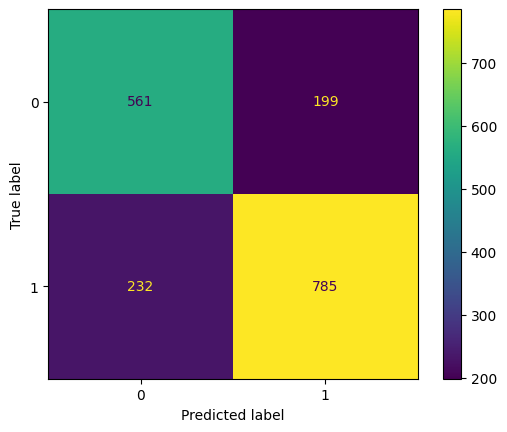

In [ ]:
pred_val = (LSTM_model.predict(X_val)> 0.5).astype(int)
ConfusionMatrixDisplay.from_predictions(y_val, pred_val)
print(classification_report(y_val, pred_val))

## testing

In [ ]:
X_test = snp500_test.drop(columns=['Direction'])
Y_test = snp500_test['Direction']

X_test = scaler.transform(X_test)
X_test_pca = pca.transform(X_test)

tempX, tempY = create_dataset(X_test_pca, Y_test, look_back)

Y_pred = LSTM_model.predict(tempX)
Y_pred_labels = (Y_pred > 0.5).astype(int)

cm = confusion_matrix(tempY, Y_pred_labels)
print(cm)

print(classification_report(tempY, Y_pred_labels))

3/3 [==============================] - 0s 12ms/step
[[21 24]
 [ 8 38]]
              precision    recall  f1-score   support

           0       0.72      0.47      0.57        45
           1       0.61      0.83      0.70        46

    accuracy                           0.65        91
   macro avg       0.67      0.65      0.64        91
weighted avg       0.67      0.65      0.64        91



In [ ]:
import json

list_to_save = tempY.tolist()
with open('LSTM_y_test_list.json', 'w') as f:
    json.dump(list_to_save, f)

list_to_save = Y_pred_labels.tolist()
with open('LSTM_y_pred_list.json', 'w') as f:
    json.dump(list_to_save, f)

In [ ]:
# reference
# https://github.com/arogan178/lstm-stock-prediction-sp500/blob/master/LSTM-price-prediction-sp500.ipynb